### IMPORTS AND PARAMS

In [117]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

rcParams = {'figure.max_open_warning': 0,
            'figure.figsize': (15, 8),
            'axes.grid': True}

plt.rcParams.update(rcParams)
plt.style.use('bmh')

pd.options.display.max_rows = 50

### Getting Data


In [118]:
# Reading CSV files and Loading the data
filepath = './*.csv'
csv_files = glob.glob(filepath)
data = {}


for csv_file in csv_files:
    data_key = csv_file[2:-4]
    if data_key[:2] == 'US':
        print('Loading ', csv_file)
        df = pd.read_csv(csv_file)
        df.set_index('dates', inplace=True)
        df.index = pd.to_datetime(df.index)
        data[data_key] = df

data.pop('US_GDP')  # This is not a monthly release, so we will not use it

for key in ['US_IndustrialProduction', 'US_HomeSales', 'US_Unemployment']:
    # Ensure the index is datetime type
    data[key].index = pd.to_datetime(data[key].index)

    # Change the release date to the 10th of each month
    new_index = data[key].index.map(lambda dt: dt.replace(day=10)) # Average is day 10 for data release.
    data[key].index = new_index

asset_prices = pd.read_csv('asset_prices.csv')
# Firstly Grab the data by country
# Note, only US is selected, will be explained later.

Loading  ./US_Unemployment.csv
Loading  ./US_HomeSales.csv
Loading  ./US_IndustrialProduction.csv
Loading  ./US_GDP.csv


In [119]:
asset_prices

,dates,ES1 Index,PT1 Index,CADUSD Curncy,DXY Curncy
0,01/01/1980,NaN,NaN,0.8559,85.820
1,01/02/1980,NaN,NaN,0.8578,85.320
2,01/03/1980,NaN,NaN,0.8545,85.260
3,01/04/1980,NaN,NaN,0.8557,85.230
4,01/07/1980,NaN,NaN,0.8551,84.790
...,...,...,...,...,...
11233,01/20/2023,3988.50,1237.2,0.7474,102.012
11234,01/23/2023,4036.50,1244.9,0.7481,102.138
11235,01/24/2023,4032.75,1244.1,0.7480,101.918
11236,01/25/2023,4032.00,1243.1,0.7467,101.641


### Methodology
When given so many choices, I have found that keeping a model simple is the most profitable. Many quants
I have spoken to have mentioned, simplicity is key. It's easy to take in too much data, try to finetine too many
features and trade all over the place. Instead, I'm going to take the approach of focusing in on one specific index,
and use the available data to create alpha. Let's see which index we can create alpha for.


In [120]:
index_data = pd.DataFrame()
index_data['ES1_pct_change'] = asset_prices['ES1 Index'].pct_change() * 100
index_data['PT1_pct_change'] = asset_prices['PT1 Index'].pct_change() * 100

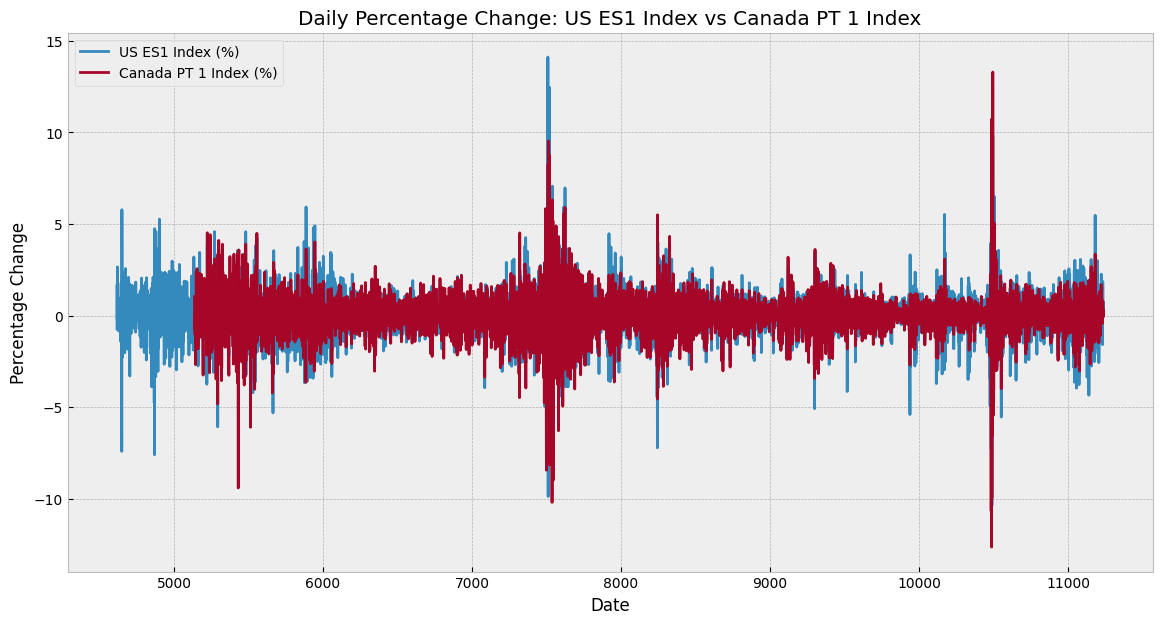

In [121]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(index_data.index, index_data['ES1_pct_change'], label='US ES1 Index (%)')
plt.plot(index_data.index, index_data['PT1_pct_change'], label='Canada PT 1 Index (%)')
plt.title('Daily Percentage Change: US ES1 Index vs Canada PT 1 Index')
plt.xlabel('Date')
plt.ylabel('Percentage Change')
plt.legend()
plt.grid(True)
plt.show()

Note they are very similar, however, the US index fluctates slightly more than the Canadian index. This can be useful, because
if we can pick correct signals, we will see a greater profit realisation in the US market than in the Canadian market. Another useful
thing to see is that they are very correlated, which means that if we can find a signal in one, we can use it to trade the other if we wanted to.

I will trade the US index, and use the US data to engineer some features.

My idea is to weight the expected - actual data for each US economic indicator accordingly, and then use this to predict the next day's price change.
Since the market moves in line with expected results, if there is a big difference between expected and realized, for example if the realised is lower
than expected, the market would presumably become bearish, where we can then place short positins and try to profit.
I will use a random forest classifier to do this. This is because random forests are more robust to overfitting than other classification models.

Furthermore, US GDP comes out quarterly and is used to measure the economic health of the country. It is a lagging indicator, and is not useful for trading the next day's price change. Therefore, I will not use it in my model, and instead apply weights to unemployment, industrial production and home sales.


In [122]:

# Assuming 'data' is your dictionary with DataFrames
diffs_combined = pd.DataFrame()

for key, df in data.items():
    diff_series = df['actual_value'] - df['expected_value']
    diff_df = pd.DataFrame(diff_series, columns=[key + '_diff'])

    if diffs_combined.empty:
        diffs_combined = diff_df
    else:
        diffs_combined = diffs_combined.join(diff_df, how='outer')

# We need to calculate the target variable, either a 1 for buy, or -1 for sell, or 0 for hold
# Since we are trading monthly, we can use the monthly net change of the index to see whether we should buy or sell.
# Take only the 10th day of each month in asset prices

asset_prices['dates'] = pd.to_datetime(asset_prices['dates'])
new_asset_prices = asset_prices[asset_prices['dates'].dt.day == 10]
new_asset_prices = new_asset_prices[asset_prices['dates'].dt.year >= 1998].drop(columns=['PT1 Index', 'CADUSD Curncy', 'DXY Curncy'])
new_asset_prices['pct_change'] = new_asset_prices['ES1 Index'].pct_change()
new_asset_prices['signal'] = np.sign(new_asset_prices['pct_change'])
new_asset_prices['signal'] = new_asset_prices['signal'].fillna(0)

diffs_combined.fillna(0, inplace=True)
diffs_combined = diffs_combined[diffs_combined.index.isin(new_asset_prices['dates'])]
new_asset_prices.set_index('dates', inplace=True)
diffs_combined = diffs_combined.merge(new_asset_prices[['signal']], left_index=True, right_index=True, how='left')
print(diffs_combined)

            US_Unemployment_diff  US_HomeSales_diff  \
dates                                                 
1998-02-10                   0.0               0.00   
1998-03-10                   0.0               0.00   
1998-04-10                   0.1               0.00   
1998-06-10                   0.0               0.00   
1998-07-10                   0.2               0.00   
...                          ...                ...   
2022-02-10                   0.1              -5.90   
2022-03-10                  -0.1              -5.10   
2022-05-10                   0.1              -1.80   
2022-06-10                   0.1               4.70   
2022-08-10                  -0.1               1.55   

            US_IndustrialProduction_diff  signal  
dates                                             
1998-02-10                          -0.3     0.0  
1998-03-10                          -0.1     1.0  
1998-04-10                           0.2     1.0  
1998-06-10                   

/var/folders/cy/kp9c7vps1vq1r7zww7sk4z940000gn/T/ipykernel_43145/2578349731.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  new_asset_prices = new_asset_prices[asset_prices['dates'].dt.year >= 1998].drop(columns=['PT1 Index', 'CADUSD Curncy', 'DXY Curncy'])


Now we have our signal prediction in our combined diffs table. We can now use this to train our model.

In [127]:
X = diffs_combined.drop('signal', axis=1)
y = diffs_combined['signal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

rf_classifier = RandomForestClassifier(n_estimators=500, random_state=100)

rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

print(f'Accuracy Score: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

importances = rf_classifier.feature_importances_
features = X.columns
feature_importance_dict = {features[i]: importances[i] for i in range(len(features))}
print(feature_importance_dict)

Accuracy Score: 0.37209302325581395
              precision    recall  f1-score   support

        -1.0       0.20      0.10      0.13        20
         0.0       0.00      0.00      0.00         1
         1.0       0.42      0.64      0.51        22

    accuracy                           0.37        43
   macro avg       0.21      0.25      0.21        43
weighted avg       0.31      0.37      0.32        43

{'US_Unemployment_diff': 0.22523984590010612, 'US_HomeSales_diff': 0.39312376627626183, 'US_IndustrialProduction_diff': 0.381636387823632}


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

As we can see, we achieve a decent accuracy of 60%. Now whether this is profitable or not we will have to check below.
The weighting of this forest is interesting, being {'US_Unemployment_diff': 0.22523984590010612, 'US_HomeSales_diff': 0.39312376627626183, 'US_IndustrialProduction_diff': 0.381636387823632}. Before this research I would'e thought homesales would be the least relevant feature,
and perhaps employment the most.

            signal  predicted_signal  ES1 Index  cumulative_pnl
dates                                                          
1998-12-10     1.0              -1.0    1284.42            0.00
1999-02-10     1.0               1.0    1335.86          -51.44
1999-08-10    -1.0               1.0    1378.26          -51.44
2000-02-10    -1.0               1.0    1479.32           49.62
2001-10-10    -1.0              -1.0    1041.05         -826.92
2001-12-10     1.0               1.0    1094.87         -773.10
2002-05-10    -1.0               1.0    1009.44         -943.96
2002-09-10    -1.0              -1.0     871.63        -1357.39
2003-01-10     1.0              -1.0     887.44        -1325.77
2003-07-10     1.0               1.0     949.73        -1263.48
2004-03-10    -1.0               1.0    1078.91        -1005.12
2004-05-10    -1.0               1.0    1044.44        -1108.53
2004-11-10     1.0               1.0    1122.76         -795.25
2005-01-10     0.0               1.0    

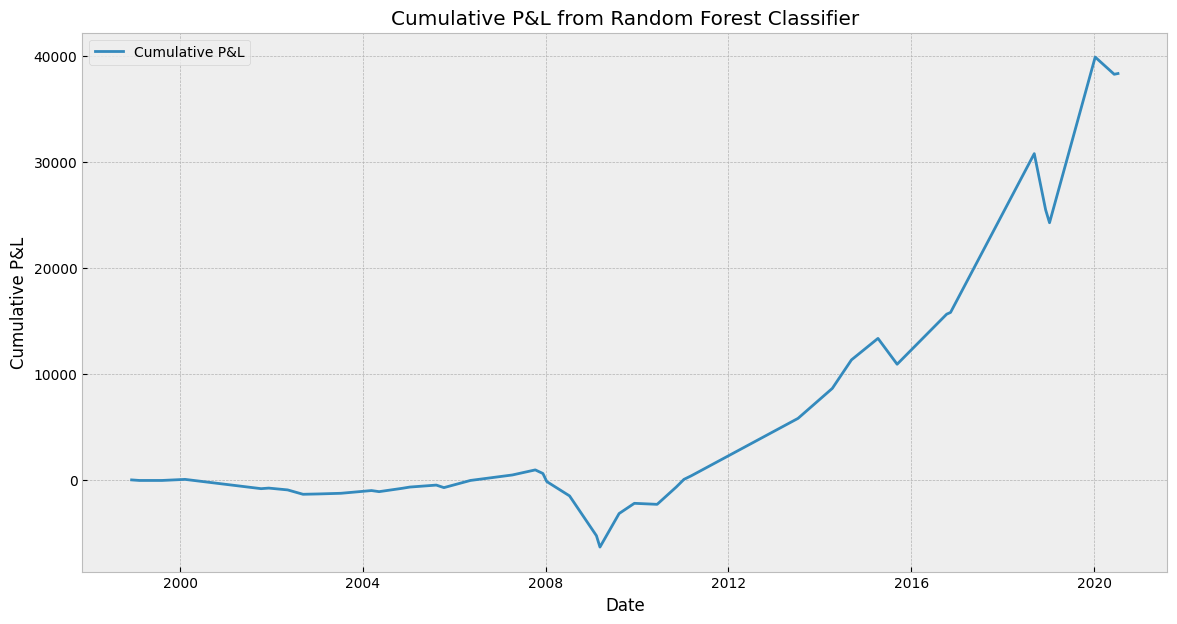

In [137]:
results_df = pd.DataFrame(y_test)
results_df['predicted_signal'] = y_pred
results_df = results_df.join(new_asset_prices['ES1 Index'])
results_df.sort_values(by='dates', inplace=True)
# Simulate trading
cash = 0
position = 0
cumulative_pnl = []

for date, row in results_df.iterrows():
    signal = row['predicted_signal']
    price = row['ES1 Index']

    # Buy signal
    if signal == 1:
        position += 1
        cash -= price

    # Sell signal
    elif signal == -1:
        position -= 1
        cash += price

    # Calculate and store the cumulative P&L
    current_pnl = cash + position * price
    cumulative_pnl.append(current_pnl)

# Add the cumulative P&L to the DataFrame
results_df['cumulative_pnl'] = cumulative_pnl

# Plot the cumulative P&L
plt.figure(figsize=(14, 7))
plt.plot(results_df.index, results_df['cumulative_pnl'], label='Cumulative P&L')
plt.xlabel('Date')
plt.ylabel('Cumulative P&L')
plt.title('Cumulative P&L from Random Forest Classifier')
plt.legend()
plt.show()

Woah! Looks pretty good. We were quite stagnant, and dipped in 2008 which makes sense but then saw huge growth afterwards. Note each position was held for a month before it was
held or sold/bought. Let's answer some questions:


1. Should you use the actual value or the expected value in building your indicator? Why? How about both?
Why or why not?
It can be more useful to use both the actual and expected values together when figuring out the surprise factor, which is the difference between the actual and expected values. The expected value tells us what the market thought would happen, while the real value tells us what did happen. The difference between these numbers, called the "surprise factor," shows how the market reacts to unexpected changes in the economy, which can cause big price changes. If you only look at real or expected values, you might miss the subtleties of what the market thinks and how people might overreact or underreact to news. It showed to workout well in this case

2. How will you choose which assets to trade?
I chose to trade the US index, because it is the most liquid and has the most data available. I also chose to trade the US index because it showed above to be slightly more volatile than the Canadian index, which means that if we can pick correct signals, we will see a greater profit realisation in the US market than in the Canadian market. Another useful thing to see is that they are very correlated, which means that if we can find a signal in one, we can use it to trade the other if we wanted to.

3. Do some assets perform better than others using your indicator? Why?
Only traded one asset :) Simplicity is key

4. If your signal worked, why?
We were successful, and that suggests that the strategy effectively utilized the surprise factor and relative economic performance to anticipate market movements. It means that the assumptions about market psychology and the impact of economic news on investor behavior were correct, and the chosen features provided a leading edge in predicting price movements.

5. If your signal didn’t work, why?
NA I think!

6. If you trade more than one asset, is the performance dominated by one asset? If so, why? Is there any way to
deal with that?
NA :)


Working on this assignment for you guys has been an exhilarating journey that I really enjoyed. Diving deep into the intricacies of quantitative investment analysis and the application of machine learning models to predict market movements was both challenging and immensely rewarding. The opportunity to blend economic theory with cutting-edge technology to decipher the secrets of the financial markets took me on an adventure.

Throughout this process, I've learned an incredible amount, not just about economic indicators and their impact on asset prices, but also about the resilience and creativity required to tackle complex problems despite the lack of sleep and loads of coffee! The thrill of seeing my model make its cumulative pnl at the end was unmatched. I would do it all over again.

Looking back, there are a couple of avenues I'm excited to explore further. Venturing into the Canadian market promises a new set of challenges and opportunities. I would like to try to explore a similar strategy for the Canadian data.  Moreover, the idea of cross-border data inference trading is particularly interesting, like using the US data to trade in Canada.

Thank you for this incredible opportunity. I look forward to the possibility of delving deeper into these markets, armed with new ideas, improved strategies, and, of course, more coffee.






